Nama : Muhammad Fadli Ramadhan

gmail: fadlinisasileader@gmail.com

Proyek Akhir : Image Classification Model Deployment

Sabtu, 03 Juli 2021

In [6]:
# Import Library sesuai kebutuhan
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import zipfile,os,shutil
from matplotlib import pyplot as plt

# Load Dataset berisi image image berformat zip
# Dataset diambil dari tugas akhir kelas Belajar Machine Learning untuk Pemula
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-07-03 05:48:54--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  5.05MB/s    in 92s     

2021-07-03 05:50:26 (3.36 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



In [9]:
# Mengekstrak file zip yang telah di import ke Files pada Google Colab
import zipfile,os
local_zip = '/tmp/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [11]:
# untuk membuat plot yang terjadi secara langsung, instal dulu Library livelossplot
!pip install livelossplot

In [12]:
# Mengecek versi tensorflow masing-masing perangkat
print(tf.__version__)

2.5.0


In [23]:
# Library untuk matplotlib, optimizer, preprocessing, layers, models, callbacks, dan livelossplot
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from livelossplot import PlotLossesKerasTF

# preprocessing dataset nya
base_dir = '/tmp/rockpaperscissors/rps-cv-images' # ini direktori dataset rock paper scissors
img_size = 255  #ukuran gambar nya
bs = 64   #ukuran Batch size nya

datagen = ImageDataGenerator(     #Membuat Datagen
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    validation_split=0.2 ,   
                           
)

train_generator = datagen.flow_from_directory(      # data generator train
    base_dir,
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='categorical',
    subset='training',      #train data
    shuffle=True
)



Found 1751 images belonging to 3 classes.


In [24]:
val_generator = datagen.flow_from_directory(      # Data Generator Test
    base_dir,
    target_size=(img_size, img_size),
    batch_size=bs,
    class_mode='categorical',
    subset='validation',    #val data
     shuffle=False
)

Found 437 images belonging to 3 classes.


In [12]:
# Model Sequential menggunakan Conv2D MaxPooling Layer
model = Sequential()

# First 
model.add(Conv2D(32, 3, activation='relu', padding='same',
                 input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.25))

# Second 
model.add(Conv2D(32, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.25))

# Third
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.25))

# Fourth
model.add(Conv2D(64, 3, activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2, padding='same'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 255, 255, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)       

In [13]:
# Optimizer dengan learning rate
adam = Adam(lr=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [14]:
# Melakukan Callbacks
# Membuat directory untuk akurasi dan loss pada folder di google colabs
filepath_acc='/content/output-models/acc_weights.hdf5'
filepath_loss='/content/output-models/loss_weights.hdf5'

# Membuat model chechpoint untuk acc dan loss model
checkpoint_loss = ModelCheckpoint(filepath_loss, verbose=1, monitor='val_loss',
                                  save_best_only=True, mode='min')
checkpoint_acc = ModelCheckpoint(filepath_acc, verbose=1, monitor='val_accuracy',
                                 save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, 
                               patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.1,
                              patience=3, min_delta=1e-4, verbose=1)
callbacks_list = [PlotLossesKerasTF(), checkpoint_loss, checkpoint_acc,
                  early_stopping, lr_reduce]
                                 

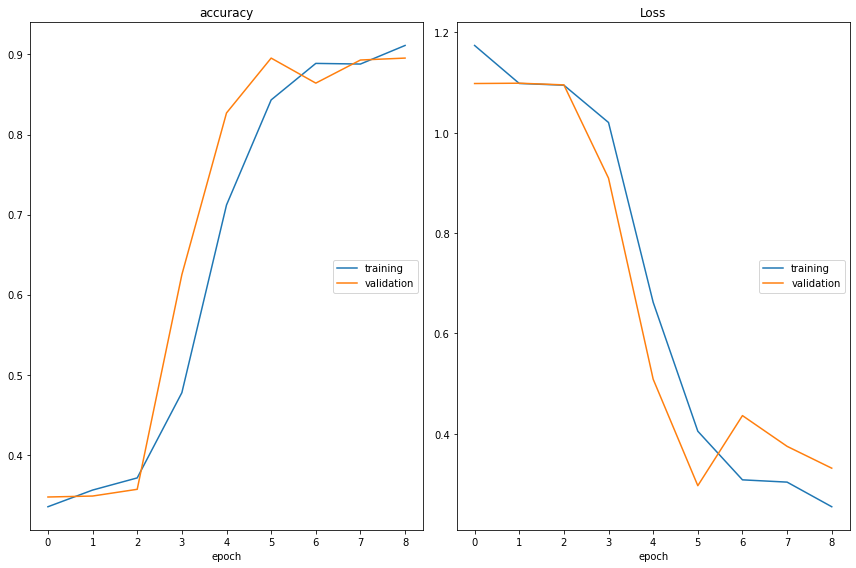

accuracy
	training         	 (min:    0.335, max:    0.911, cur:    0.911)
	validation       	 (min:    0.347, max:    0.895, cur:    0.895)
Loss
	training         	 (min:    0.255, max:    1.174, cur:    0.255)
	validation       	 (min:    0.297, max:    1.099, cur:    0.332)

Epoch 00009: val_loss did not improve from 0.29677

Epoch 00009: val_accuracy did not improve from 0.89543
Restoring model weights from the end of the best epoch.

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 00009: early stopping
CPU times: user 47min 58s, sys: 38.1 s, total: 48min 36s
Wall time: 27min 18s


In [15]:
%%time
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = val_generator.n//val_generator.batch_size

history = model.fit(
        train_generator, 
        steps_per_epoch=steps_per_epoch,
        epochs=15, 
        validation_data=val_generator,
        validation_steps=validation_steps, 
        verbose=1,
       
        callbacks=callbacks_list
    )

In [16]:
# Evaluasi Model
eval_val = model.evaluate(val_generator, steps=validation_steps)
print("\Val Loss" + str(eval_val[0]))
print("Val Acc: " + str(eval_val[1]))

13/13 [==============================] - 33s 2s/step - loss: 0.3043 - accuracy: 0.8774
\Val Loss0.3042888343334198
Val Acc: 0.8774038553237915


Saving Tangan Bentuk Gunting.png to Tangan Bentuk Gunting.png
Tangan Bentuk Gunting.png
[2]
Predict : Scissors


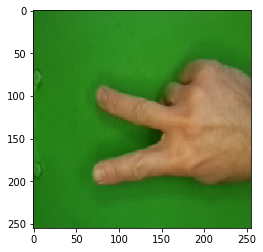

In [17]:
# Prediksi Model
from tensorflow.keras.models import load_model
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
model = load_model(filepath_acc)
uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(255,255))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=32)
  predIdxs = np.argmax(classes, axis=1)
  print(fn)
  print(predIdxs)
  if classes[0, 0] !=0:
    print('Predict : Paper')
  elif classes[0, 1] !=0:
    print('Predict : Rock')  
  else :
    print('Predict : Scissors')


In [19]:
# Menyimpan Model ke Format TF-Lite
# Mengkonversi Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan Model
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp6g4vf6zw/assets
